In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import gc
import warnings
import lightgbm as lgb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score,roc_auc_score,accuracy_score,roc_curve, plot_roc_curve

def reduce_mem_usage(data, verbose = True):
    start_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('Memory usage of dataframe: {:.2f} MB'.format(start_mem))
    
    for col in data.columns:
        col_type = data[col].dtype
        
        if col_type != object:
            c_min = data[col].min()
            c_max = data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    data[col] = data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    data[col] = data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    data[col] = data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    data[col] = data[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    data[col] = data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    data[col] = data[col].astype(np.float32)
                else:
                    data[col] = data[col].astype(np.float64)

    end_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('Memory usage after optimization: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return data
def split_train(data,test_ratio):
   #  data = data.iloc[0:20000,:]
    shuffled_indices=np.random.permutation(len(data))
    test_set_size=int(len(data)*test_ratio)
    test_indices =shuffled_indices[:test_set_size]
    train_indices=shuffled_indices[test_set_size:]
    return data.iloc[train_indices],data.iloc[test_indices]

In [32]:
data_A = pd.read_csv("C:/data/processing_data/data_app.csv")
data_A = reduce_mem_usage(data_A)
data_A.shape

Memory usage of dataframe: 520.84 MB
Memory usage after optimization: 130.50 MB
Decreased by 74.9%


(307511, 222)

In [33]:
data_A.head(10)

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_0,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET
0,100002,-0.324463,-0.717773,0.664551,-0.577637,0.142090,-0.478027,-0.166016,-0.505859,-0.149658,...,-0.086731,-0.076294,-0.072876,-0.522949,1.934570,-0.133179,-0.949219,0.963867,-0.087341,1
1,100003,-0.324463,-0.717773,-1.504883,-0.577637,0.426758,1.725586,0.592773,1.600586,-1.252930,...,-0.086731,-0.076294,-0.072876,-0.522949,-0.516602,-0.133179,-0.949219,0.963867,-0.087341,0
2,100004,3.082031,1.392578,0.664551,-0.577637,-0.427246,-1.153320,-1.404297,-1.089844,-0.783203,...,-0.086731,-0.076294,-0.072876,-0.522949,-0.516602,-0.133179,1.053711,-1.038086,-0.087341,0
3,100006,-0.324463,-0.717773,0.664551,-0.577637,-0.142578,-0.711426,0.177979,-0.651855,-0.929199,...,-0.086731,-0.076294,-0.072876,-0.522949,-0.516602,-0.133179,1.053711,-1.038086,-0.087341,0
4,100007,-0.324463,-0.717773,0.664551,-0.577637,-0.199463,-0.213745,-0.361572,-0.067383,0.562988,...,-0.086731,-0.076294,-0.072876,-0.522949,-0.516602,-0.133179,1.053711,-1.038086,-0.087341,0
5,100008,-0.324463,-0.717773,0.664551,-0.577637,-0.294434,-0.269531,0.028290,-0.225708,1.079102,...,-0.086731,-0.076294,-0.072876,-0.522949,-0.516602,-0.133179,1.053711,-1.038086,-0.087341,0
6,100009,-0.324463,1.392578,0.664551,0.807129,0.009285,2.388672,0.979004,2.318359,1.079102,...,-0.086731,-0.076294,-0.072876,-0.522949,-0.516602,-0.133179,1.053711,-1.038086,-0.087341,0
7,100010,-0.324463,1.392578,0.664551,-0.577637,0.806152,2.312500,1.032227,2.683594,-1.283203,...,-0.086731,-0.076294,-0.072876,-0.522949,-0.516602,-0.133179,1.053711,-1.038086,-0.087341,0
8,100011,-0.324463,-0.717773,0.664551,-0.577637,-0.237427,1.044922,0.463623,1.016602,-0.161865,...,-0.086731,-0.076294,-0.072876,-0.522949,-0.516602,-0.133179,1.053711,-1.038086,-0.087341,0
9,100012,3.082031,-0.717773,0.664551,-0.577637,-0.142578,-0.482178,-0.473145,-0.359619,-0.085693,...,-0.086731,-0.076294,-0.072876,-0.522949,-0.516602,-0.133179,1.053711,-1.038086,-0.087341,0


# 原数据

In [34]:
def split_train(data,test_ratio):
   #  data = data.iloc[0:20000,:]
    shuffled_indices=np.random.permutation(len(data))
    test_set_size=int(len(data)*test_ratio)
    test_indices =shuffled_indices[:test_set_size]
    train_indices=shuffled_indices[test_set_size:]
    return data.iloc[train_indices],data.iloc[test_indices]

In [35]:
data_A.replace([np.inf, -np.inf], np.nan, inplace=True)
data_A.fillna(0, inplace=True)
train_df, test_df = split_train(data_A, 0.2)
feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X_train = train_df[feats].to_numpy()
y_train = train_df['TARGET'].values  
X_test = test_df[feats].to_numpy()                   
y_test = test_df['TARGET'].values

In [36]:
def model_process(X_train, y_train,X_test,y_test):
    
    # LR
    LR = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, max_iter=500, multi_class='auto',
                            random_state=42, solver='sag',n_jobs=-1)
    
#     # GaussianNB
#     gnb = GaussianNB()
    
#     # KNeighbors
#     knc = KNeighborsClassifier(n_neighbors=5)
    
    # DNN
    dnn = MLPClassifier(hidden_layer_sizes=(400,),activation='relu',max_iter=300, alpha=0.01,learning_rate_init = 0.01, learning_rate= 'constant')
    
    # 决策树
    clf=DecisionTreeClassifier(random_state=0)
    
    # 随机森林
    rfc=RandomForestClassifier(n_estimators=100)
      
    # 集成学习 adaBoost
    ada = AdaBoostClassifier(n_estimators=100, random_state=0)
    
    # gbm
    gbm = lgb.LGBMClassifier()
    
    # LR
    print("=============================逻辑回归================================")
    print("训练开始")
    LR = LR.fit(X_train,y_train)
    print("训练结束")
    y_pred = LR.predict(X_test)

    print("训练集精确度:{%.3f}    "%LR.score(X_train, y_train), "测试集精确度:{%.3f}    \n"%LR.score(X_test, y_test))
    #print("predict 训练集auc:{%.3f} "%metrics.roc_auc_score(y_train, clf.predict(X_train)), "训练集auc:{%.3f}\n"%metrics.roc_auc_score(y_test, clf.predict(X_test)))
    print("predict_proba 训练集auc:{%.3f} "%metrics.roc_auc_score(y_train, LR.predict_proba(X_train)[:,1]), 
          "训练集auc:{%.3f}\n"%metrics.roc_auc_score(y_test, LR.predict_proba(X_test)[:,1]))

    print("classification_report:")
    print(metrics.classification_report(y_test, y_pred))
    
    fpr,tpr,thresholds = roc_curve(y_test,LR.predict_proba(X_test)[:,1])
    ks = max(tpr-fpr)
    print("LR 的KS:{%.4f}"%ks)
#     print("=================================================================")
    
    
#     # GaussianNB
#     print("=============================GaussianNB================================")
#     print("训练开始")
#     gnb = gnb.fit(X_train,y_train.ravel())
#     print("训练结束")
#     y_pred = gnb.predict(X_test)

#     print("训练集精确度:{%.3f}    "%gnb.score(X_train, y_train), 
#         "测试集精确度:{%.3f}    \n"%gnb.score(X_test, y_test))
#     #print("predict 训练集auc:{%.3f} "%metrics.roc_auc_score(y_train, clf.predict(X_train)), "训练集auc:{%.3f}\n"%metrics.roc_auc_score(y_test, clf.predict(X_test)))
#     print("predict_proba 训练集auc:{%.3f} "%metrics.roc_auc_score(y_train, gnb.predict_proba(X_train)[:,1]), 
#                         "训练集auc:{%.3f}\n"%metrics.roc_auc_score(y_test, gnb.predict_proba(X_test)[:,1]))

#     print("classification_report:")
#     print(metrics.classification_report(y_test, y_pred))
    
#     fpr,tpr,thresholds = roc_curve(y_test,gnb.predict_proba(X_test)[:,1])
#     ks = max(tpr-fpr)
#     print("GaussianNB 的KS:{%.4f}"%ks)
#     print("=================================================================")
    

     # DNN
    print("=============================DNN================================")
    print("训练开始")
    dnn = dnn.fit(X_train,y_train.ravel())
    print("训练结束")
    y_pred = dnn.predict(X_test)

    print("训练集精确度:{%.4f}    "%dnn.score(X_train, y_train), 
        "测试集精确度:{%.4f}    \n"%dnn.score(X_test, y_test))
    #print("predict 训练集auc:{%.3f} "%metrics.roc_auc_score(y_train, clf.predict(X_train)), "训练集auc:{%.3f}\n"%metrics.roc_auc_score(y_test, clf.predict(X_test)))
    print("predict_proba 训练集auc:{%.4f} "%metrics.roc_auc_score(y_train, dnn.predict_proba(X_train)[:,1]), 
                        "训练集auc:{%.4f}\n"%metrics.roc_auc_score(y_test, dnn.predict_proba(X_test)[:,1]))

    print("classification_report:")
    print(metrics.classification_report(y_test, y_pred))
    
    
    fpr,tpr,thresholds = roc_curve(y_test,dnn.predict_proba(X_test)[:,1])
    ks = max(tpr-fpr)
    print("dnn 的KS:{%.4f}"%ks)
    print("=================================================================")
    
     # Decision Tree
    print("=============================Decision Tree================================")
    print("训练开始")
    clf = clf.fit(X_train,y_train.ravel())
    print("训练结束")
    y_pred = clf.predict(X_test)

    print("训练集精确度:{%.4f}    "%clf.score(X_train, y_train), 
        "测试集精确度:{%.4f}    \n"%clf.score(X_test, y_test))
    #print("predict 训练集auc:{%.3f} "%metrics.roc_auc_score(y_train, clf.predict(X_train)), "训练集auc:{%.3f}\n"%metrics.roc_auc_score(y_test, clf.predict(X_test)))
    print("predict_proba 训练集auc:{%.4f} "%metrics.roc_auc_score(y_train, clf.predict_proba(X_train)[:,1]), 
                        "训练集auc:{%.4f}\n"%metrics.roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))

    print("classification_report:")
    print(metrics.classification_report(y_test, y_pred))
    
    fpr,tpr,thresholds = roc_curve(y_test,clf.predict_proba(X_test)[:,1])
    ks = max(tpr-fpr)
    print("dt 的KS:{%.4f}"%ks)
    print("=================================================================")
    
    
     # Random Forest
    print("=============================Random Forest================================")
    print("训练开始")
    rfc = rfc.fit(X_train,y_train.ravel())
    print("训练结束")
    y_pred = rfc.predict(X_test)

    print("训练集精确度:{%.4f}    "%rfc.score(X_train, y_train), 
        "测试集精确度:{%.4f}    \n"%rfc.score(X_test, y_test))
    #print("predict 训练集auc:{%.3f} "%metrics.roc_auc_score(y_train, clf.predict(X_train)), "训练集auc:{%.3f}\n"%metrics.roc_auc_score(y_test, clf.predict(X_test)))
    print("predict_proba 训练集auc:{%.4f} "%metrics.roc_auc_score(y_train, rfc.predict_proba(X_train)[:,1]), 
                        "训练集auc:{%.4f}\n"%metrics.roc_auc_score(y_test, rfc.predict_proba(X_test)[:,1]))

    print("classification_report:")
    print(metrics.classification_report(y_test, y_pred))
    
    fpr,tpr,thresholds = roc_curve(y_test,rfc.predict_proba(X_test)[:,1])
    ks = max(tpr-fpr)
    print("rf 的KS:{%.4f}"%ks)
#     print("=================================================================")
    
    
    # AdaBoost
    print("=============================AdaBoost================================")
    print("训练开始")
    ada = ada.fit(X_train,y_train.ravel())
    print("训练结束")
    y_pred = ada.predict(X_test)

    print("训练集精确度:{%.4f}    "%ada.score(X_train, y_train), 
        "测试集精确度:{%.4f}    \n"%ada.score(X_test, y_test))
    #print("predict 训练集auc:{%.3f} "%metrics.roc_auc_score(y_train, clf.predict(X_train)), "训练集auc:{%.3f}\n"%metrics.roc_auc_score(y_test, clf.predict(X_test)))
    print("predict_proba 训练集auc:{%.4f} "%metrics.roc_auc_score(y_train, ada.predict_proba(X_train)[:,1]), 
                        "训练集auc:{%.4f}\n"%metrics.roc_auc_score(y_test, ada.predict_proba(X_test)[:,1]))

    print("classification_report:")
    print(metrics.classification_report(y_test, y_pred))
    
    fpr,tpr,thresholds = roc_curve(y_test,ada.predict_proba(X_test)[:,1])
    ks = max(tpr-fpr)
    print("ada 的KS:{%.4f}"%ks)
    print("=================================================================")
    
    
    # gbm
    print("=============================GBM================================")
    print("训练开始")
    gbm = gbm.fit(X_train,y_train.ravel())
    print("训练结束")
    y_pred = gbm.predict(X_test)

    print("训练集精确度:{%.4f}    "%gbm.score(X_train, y_train), 
        "测试集精确度:{%.4f}    \n"%gbm.score(X_test, y_test))
    #print("predict 训练集auc:{%.3f} "%metrics.roc_auc_score(y_train, clf.predict(X_train)), "训练集auc:{%.3f}\n"%metrics.roc_auc_score(y_test, clf.predict(X_test)))
    print("predict_proba 训练集auc:{%.4f} "%metrics.roc_auc_score(y_train, gbm.predict_proba(X_train)[:,1]), 
                        "训练集auc:{%.4f}\n"%metrics.roc_auc_score(y_test, gbm.predict_proba(X_test)[:,1]))

    print("classification_report:")
    print(metrics.classification_report(y_test, y_pred))
    
    fpr,tpr,thresholds = roc_curve(y_test,gbm.predict_proba(X_test)[:,1])
    ks = max(tpr-fpr)
    print("gbm 的KS:{%.4f}"%ks)
    print("=================================================================")
    
    return LR,dnn,clf,rfc,ada,gbm

In [37]:
LR,dnn,clf,rfc,ada,gbm = model_process(X_train, y_train, X_test, y_test)

=============================逻辑回归================================
训练开始


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


训练结束
训练集精确度:{0.919}     测试集精确度:{0.920}    

predict_proba 训练集auc:{0.714}  训练集auc:{0.719}

classification_report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56563
           1       0.50      0.00      0.00      4939

    accuracy                           0.92     61502
   macro avg       0.71      0.50      0.48     61502
weighted avg       0.89      0.92      0.88     61502

LR 的KS:{0.3248}
=============================DNN================================
训练开始
训练结束
训练集精确度:{0.9190}     测试集精确度:{0.9193}    

predict_proba 训练集auc:{0.7088}  训练集auc:{0.7141}

classification_report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56563
           1       0.35      0.01      0.01      4939

    accuracy                           0.92     61502
   macro avg       0.63      0.50      0.48     61502
weighted avg       0.87      0.92      0.88     61502

dnn 的KS:{0.3231}
=============

Text(0.5, 1.0, 'ROC curve comparison')

<Figure size 1296x576 with 0 Axes>

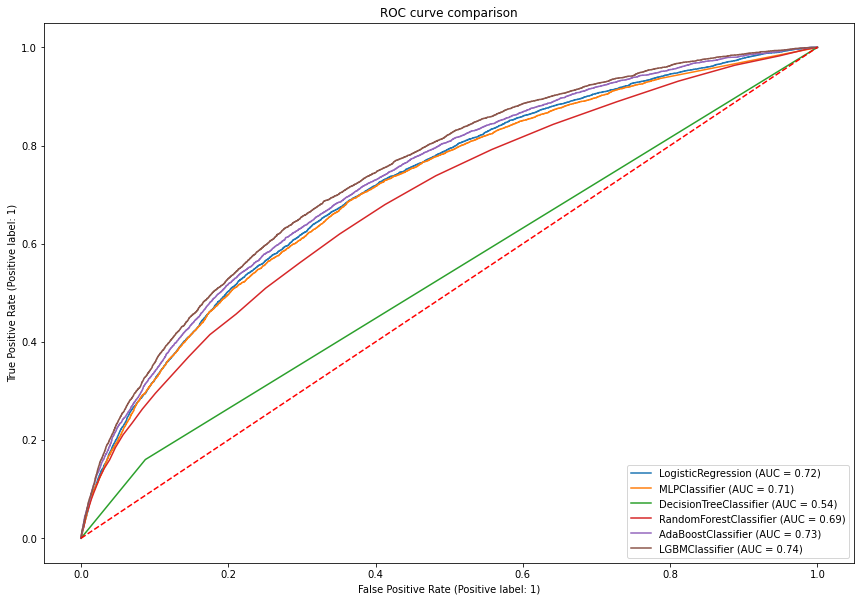

In [38]:
plt.figure(figsize=(18,8))
fig, ax = plt.subplots()
LR_disp = plot_roc_curve(LR, X_test, y_test,ax = ax)
#     example = plot_roc_curve(gbm_per, X_test_per, y_test_per, ax= ax, name = "LogostocRegression(AUC = 0.74)")
# gnb_disp = plot_roc_curve(gnb, X_test, y_test,ax = ax)
dnn_disp = plot_roc_curve(dnn, X_test, y_test,ax = ax)
clf_disp = plot_roc_curve(clf, X_test, y_test,ax = ax)
rfc_disp = plot_roc_curve(rfc, X_test, y_test,ax= ax)
ada_disp = plot_roc_curve(ada, X_test, y_test,ax= ax)
ada_disp = plot_roc_curve(gbm, X_test, y_test,ax= ax)

ax.plot([0, 1], [0, 1], linestyle='--', color='r')
plt.subplots_adjust( right=2, top = 2)
ax.set_title("ROC curve comparison")

In [ ]:
features = data_A.columns
X = X_train
y = y_train


# gbm
gbm = lgb.LGBMClassifier(
        boosting_type='gbdt',
        num_leaves=20,
        max_depth=8,
        learning_rate=0.02,
        n_estimators= 10000,
        objective='binary',
        class_weight=None,
        min_split_gain=0.0222415,
        min_child_weight=60,
        min_child_samples=200,
        subsample=0.8715623,
        subsample_freq=1,
        colsample_bytree=0.9497036,
        reg_alpha=0.041545473,
        reg_lambda=0.0735294,
        random_state=42,
        n_jobs=-1

    )

gbm.fit(X, y)

# Extract feature importances
feature_importance_values = gbm.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

def plot_feature_importances(df):
    
    df = df.sort_values('importance', ascending = False).reset_index()
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    return df

feature_importances_sorted = plot_feature_importances(feature_importances)

# application + bureau

In [16]:
bureau = pd.read_csv("C:/data/processing_data/bureau.csv")
bureau = reduce_mem_usage(bureau)
bureau.shape

Memory usage of dataframe: 170.32 MB
Memory usage after optimization: 60.08 MB
Decreased by 64.7%


(305811, 73)

In [11]:
 bureau.drop(labels = ["SK_ID_CURR"], axis = 1, inplace = True)

In [18]:
data_B = pd.concat([data_A, bureau], axis = 1)
del bureau
gc.collect()
data_A.shape

(307511, 295)

In [19]:
data_A

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,NEW_RATIO_BURO_DAYS_CREDIT_MAX,NEW_RATIO_BURO_DAYS_CREDIT_MEAN,NEW_RATIO_BURO_DAYS_CREDIT_VAR,NEW_RATIO_BURO_DAYS_CREDIT_ENDDATE_MIN,NEW_RATIO_BURO_DAYS_CREDIT_ENDDATE_MAX,NEW_RATIO_BURO_DAYS_CREDIT_ENDDATE_MEAN,NEW_RATIO_BURO_DAYS_CREDIT_UPDATE_MEAN,NEW_RATIO_BURO_AMT_CREDIT_SUM_MAX,NEW_RATIO_BURO_AMT_CREDIT_SUM_MEAN,NEW_RATIO_BURO_AMT_CREDIT_SUM_SUM
0,100002,-0.324463,-0.717773,0.664551,-0.577637,0.142090,-0.478027,-0.166016,-0.505859,-0.149658,...,0.057190,0.293457,0.544427,-0.309326,-9.929688,-1.638672,0.068848,1.351351,2.070292,1.552719
1,100003,-0.324463,-0.717773,-1.504883,-0.577637,0.426758,1.725586,0.592773,1.600586,-1.252930,...,0.216431,0.587402,3.556569,-0.727539,9.179688,-1.356445,0.023438,3.333333,3.774707,1.258236
2,100004,3.082031,1.392578,0.664551,-0.577637,-0.427246,-1.153320,-1.404297,-1.089844,-0.783203,...,0.781738,0.363770,0.000000,-0.499512,-2.894531,-1.075195,0.040039,7.200000,11.716461,3.905487
3,100006,-0.324463,-0.717773,0.664551,-0.577637,-0.142578,-0.711426,0.177979,-0.651855,-0.929199,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,100007,-0.324463,-0.717773,0.664551,-0.577637,-0.199463,-0.213745,-0.361572,-0.067383,0.562988,...,0.166260,0.266846,0.000000,-0.953125,-10.343750,-5.648438,0.173584,9.723077,5.116462,10.232924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,-0.324463,-0.717773,-1.504883,-0.577637,-0.047638,-0.855469,0.031082,-0.846680,0.845215,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,-0.324463,-0.717773,0.664551,-0.577637,-0.408203,-0.818359,-1.041992,-0.846680,0.310303,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,-0.324463,-0.717773,0.664551,-0.577637,-0.066650,0.195435,0.198120,0.127441,-1.147461,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307509,456254,-0.324463,-0.717773,0.664551,-0.577637,0.009285,-0.568848,-0.476318,-0.590820,-1.124023,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
def split_train(data,test_ratio):
   #  data = data.iloc[0:20000,:]
    shuffled_indices=np.random.permutation(len(data))
    test_set_size=int(len(data)*test_ratio)
    test_indices =shuffled_indices[:test_set_size]
    train_indices=shuffled_indices[test_set_size:]
    return data.iloc[train_indices],data.iloc[test_indices]

In [25]:

data_A.replace([np.inf, -np.inf], np.nan, inplace=True)
data_A.fillna(0, inplace=True)
train_df, test_df = split_train(data_B, 0.2)
feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X_train = train_df[feats].to_numpy()
y_train = train_df['TARGET'].values  
X_test = test_df[feats].to_numpy()                   
y_test = test_df['TARGET'].values

In [26]:
def model_process(X_train, y_train,X_test,y_test):
    
    # LR
    LR = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, max_iter=500, multi_class='auto',
                            random_state=42, solver='sag',n_jobs=-1)
    
#     # GaussianNB
#     gnb = GaussianNB()
    
#     # KNeighbors
#     knc = KNeighborsClassifier(n_neighbors=5)
    
    # DNN
    dnn = MLPClassifier(hidden_layer_sizes=(400,),activation='relu',max_iter=300, alpha=0.01,learning_rate_init = 0.01, learning_rate= 'constant')
    
    # 决策树
    clf=DecisionTreeClassifier(random_state=0)
    
    # 随机森林
    rfc=RandomForestClassifier(n_estimators=100)
      
    # 集成学习 adaBoost
    ada = AdaBoostClassifier(n_estimators=100, random_state=0)
    
    # gbm
    gbm = lgb.LGBMClassifier()
    
    # LR
    print("=============================逻辑回归================================")
    print("训练开始")
    LR = LR.fit(X_train,y_train)
    print("训练结束")
    y_pred = LR.predict(X_test)

    print("训练集精确度:{%.3f}    "%LR.score(X_train, y_train), "测试集精确度:{%.3f}    \n"%LR.score(X_test, y_test))
    #print("predict 训练集auc:{%.3f} "%metrics.roc_auc_score(y_train, clf.predict(X_train)), "训练集auc:{%.3f}\n"%metrics.roc_auc_score(y_test, clf.predict(X_test)))
    print("predict_proba 训练集auc:{%.3f} "%metrics.roc_auc_score(y_train, LR.predict_proba(X_train)[:,1]), 
          "训练集auc:{%.3f}\n"%metrics.roc_auc_score(y_test, LR.predict_proba(X_test)[:,1]))

    print("classification_report:")
    print(metrics.classification_report(y_test, y_pred))
    
    fpr,tpr,thresholds = roc_curve(y_test,LR.predict_proba(X_test)[:,1])
    ks = max(tpr-fpr)
    print("LR 的KS:{%.4f}"%ks)
#     print("=================================================================")
    
    
#     # GaussianNB
#     print("=============================GaussianNB================================")
#     print("训练开始")
#     gnb = gnb.fit(X_train,y_train.ravel())
#     print("训练结束")
#     y_pred = gnb.predict(X_test)

#     print("训练集精确度:{%.3f}    "%gnb.score(X_train, y_train), 
#         "测试集精确度:{%.3f}    \n"%gnb.score(X_test, y_test))
#     #print("predict 训练集auc:{%.3f} "%metrics.roc_auc_score(y_train, clf.predict(X_train)), "训练集auc:{%.3f}\n"%metrics.roc_auc_score(y_test, clf.predict(X_test)))
#     print("predict_proba 训练集auc:{%.3f} "%metrics.roc_auc_score(y_train, gnb.predict_proba(X_train)[:,1]), 
#                         "训练集auc:{%.3f}\n"%metrics.roc_auc_score(y_test, gnb.predict_proba(X_test)[:,1]))

#     print("classification_report:")
#     print(metrics.classification_report(y_test, y_pred))
    
#     fpr,tpr,thresholds = roc_curve(y_test,gnb.predict_proba(X_test)[:,1])
#     ks = max(tpr-fpr)
#     print("GaussianNB 的KS:{%.4f}"%ks)
#     print("=================================================================")
    

     # DNN
    print("=============================DNN================================")
    print("训练开始")
    dnn = dnn.fit(X_train,y_train.ravel())
    print("训练结束")
    y_pred = dnn.predict(X_test)

    print("训练集精确度:{%.4f}    "%dnn.score(X_train, y_train), 
        "测试集精确度:{%.4f}    \n"%dnn.score(X_test, y_test))
    #print("predict 训练集auc:{%.3f} "%metrics.roc_auc_score(y_train, clf.predict(X_train)), "训练集auc:{%.3f}\n"%metrics.roc_auc_score(y_test, clf.predict(X_test)))
    print("predict_proba 训练集auc:{%.4f} "%metrics.roc_auc_score(y_train, dnn.predict_proba(X_train)[:,1]), 
                        "训练集auc:{%.4f}\n"%metrics.roc_auc_score(y_test, dnn.predict_proba(X_test)[:,1]))

    print("classification_report:")
    print(metrics.classification_report(y_test, y_pred))
    
    
    fpr,tpr,thresholds = roc_curve(y_test,dnn.predict_proba(X_test)[:,1])
    ks = max(tpr-fpr)
    print("dnn 的KS:{%.4f}"%ks)
    print("=================================================================")
    
     # Decision Tree
    print("=============================Decision Tree================================")
    print("训练开始")
    clf = clf.fit(X_train,y_train.ravel())
    print("训练结束")
    y_pred = clf.predict(X_test)

    print("训练集精确度:{%.4f}    "%clf.score(X_train, y_train), 
        "测试集精确度:{%.4f}    \n"%clf.score(X_test, y_test))
    #print("predict 训练集auc:{%.3f} "%metrics.roc_auc_score(y_train, clf.predict(X_train)), "训练集auc:{%.3f}\n"%metrics.roc_auc_score(y_test, clf.predict(X_test)))
    print("predict_proba 训练集auc:{%.4f} "%metrics.roc_auc_score(y_train, clf.predict_proba(X_train)[:,1]), 
                        "训练集auc:{%.4f}\n"%metrics.roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))

    print("classification_report:")
    print(metrics.classification_report(y_test, y_pred))
    
    fpr,tpr,thresholds = roc_curve(y_test,clf.predict_proba(X_test)[:,1])
    ks = max(tpr-fpr)
    print("dt 的KS:{%.4f}"%ks)
    print("=================================================================")
    
    
     # Random Forest
    print("=============================Random Forest================================")
    print("训练开始")
    rfc = rfc.fit(X_train,y_train.ravel())
    print("训练结束")
    y_pred = rfc.predict(X_test)

    print("训练集精确度:{%.4f}    "%rfc.score(X_train, y_train), 
        "测试集精确度:{%.4f}    \n"%rfc.score(X_test, y_test))
    #print("predict 训练集auc:{%.3f} "%metrics.roc_auc_score(y_train, clf.predict(X_train)), "训练集auc:{%.3f}\n"%metrics.roc_auc_score(y_test, clf.predict(X_test)))
    print("predict_proba 训练集auc:{%.4f} "%metrics.roc_auc_score(y_train, rfc.predict_proba(X_train)[:,1]), 
                        "训练集auc:{%.4f}\n"%metrics.roc_auc_score(y_test, rfc.predict_proba(X_test)[:,1]))

    print("classification_report:")
    print(metrics.classification_report(y_test, y_pred))
    
    fpr,tpr,thresholds = roc_curve(y_test,rfc.predict_proba(X_test)[:,1])
    ks = max(tpr-fpr)
    print("rf 的KS:{%.4f}"%ks)
#     print("=================================================================")
    
    
    # AdaBoost
    print("=============================AdaBoost================================")
    print("训练开始")
    ada = ada.fit(X_train,y_train.ravel())
    print("训练结束")
    y_pred = ada.predict(X_test)

    print("训练集精确度:{%.4f}    "%ada.score(X_train, y_train), 
        "测试集精确度:{%.4f}    \n"%ada.score(X_test, y_test))
    #print("predict 训练集auc:{%.3f} "%metrics.roc_auc_score(y_train, clf.predict(X_train)), "训练集auc:{%.3f}\n"%metrics.roc_auc_score(y_test, clf.predict(X_test)))
    print("predict_proba 训练集auc:{%.4f} "%metrics.roc_auc_score(y_train, ada.predict_proba(X_train)[:,1]), 
                        "训练集auc:{%.4f}\n"%metrics.roc_auc_score(y_test, ada.predict_proba(X_test)[:,1]))

    print("classification_report:")
    print(metrics.classification_report(y_test, y_pred))
    
    fpr,tpr,thresholds = roc_curve(y_test,ada.predict_proba(X_test)[:,1])
    ks = max(tpr-fpr)
    print("ada 的KS:{%.4f}"%ks)
    print("=================================================================")
    
    
    # gbm
    print("=============================GBM================================")
    print("训练开始")
    gbm = gbm.fit(X_train,y_train.ravel())
    print("训练结束")
    y_pred = gbm.predict(X_test)

    print("训练集精确度:{%.4f}    "%gbm.score(X_train, y_train), 
        "测试集精确度:{%.4f}    \n"%gbm.score(X_test, y_test))
    #print("predict 训练集auc:{%.3f} "%metrics.roc_auc_score(y_train, clf.predict(X_train)), "训练集auc:{%.3f}\n"%metrics.roc_auc_score(y_test, clf.predict(X_test)))
    print("predict_proba 训练集auc:{%.4f} "%metrics.roc_auc_score(y_train, gbm.predict_proba(X_train)[:,1]), 
                        "训练集auc:{%.4f}\n"%metrics.roc_auc_score(y_test, gbm.predict_proba(X_test)[:,1]))

    print("classification_report:")
    print(metrics.classification_report(y_test, y_pred))
    
    fpr,tpr,thresholds = roc_curve(y_test,gbm.predict_proba(X_test)[:,1])
    ks = max(tpr-fpr)
    print("gbm 的KS:{%.4f}"%ks)
    print("=================================================================")
    
#     plt.figure(figsize=(18,8))
#     fig, ax = plt.subplots()
#     LR_disp = plot_roc_curve(LR, X_test, y_test,ax = ax)
# #     example = plot_roc_curve(gbm_per, X_test_per, y_test_per, ax= ax, name = "LogostocRegression(AUC = 0.74)")
#     gnb_disp = plot_roc_curve(gnb, X_test, y_test,ax = ax)
#     dnn_disp = plot_roc_curve(dnn, X_test, y_test,ax = ax)
#     clf_disp = plot_roc_curve(clf, X_test, y_test,ax = ax)
#     rfc_disp = plot_roc_curve(rfc, X_test, y_test,ax= ax)
#     ada_disp = plot_roc_curve(ada, X_test, y_test,ax= ax)
#     ada_disp = plot_roc_curve(gbm, X_test, y_test,ax= ax)
    
#     ax.plot([0, 1], [0, 1], linestyle='--', color='r')
#     plt.subplots_adjust( right=2, top = 2)
    # LR_disp.figure_.suptitle("ROC curve comparison")
#     ax.set_title("ROC curve comparison")
#     plt.savefig("C:/Users/Wang/Desktop/SEUTHESIS/校庆论文/picture1.png")
#     plt.show()
    return LR,dnn,clf,rfc,ada,gbm

In [27]:
LR,dnn,clf,rfc,ada,gbm = model_process(X_train, y_train, X_test, y_test)

=============================逻辑回归================================
训练开始


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


训练结束
训练集精确度:{0.918}     测试集精确度:{0.916}    

predict_proba 训练集auc:{0.501}  训练集auc:{0.503}

classification_report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56463
           1       0.13      0.00      0.01      5039

    accuracy                           0.92     61502
   macro avg       0.52      0.50      0.48     61502
weighted avg       0.85      0.92      0.88     61502

LR 的KS:{0.0126}
=============================DNN================================
训练开始
训练结束
训练集精确度:{0.9194}     测试集精确度:{0.9179}    

predict_proba 训练集auc:{0.5013}  训练集auc:{0.4992}

classification_report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56463
           1       0.08      0.00      0.00      5039

    accuracy                           0.92     61502
   macro avg       0.50      0.50      0.48     61502
weighted avg       0.85      0.92      0.88     61502

dnn 的KS:{0.0002}
=============

Text(0.5, 1.0, 'ROC curve comparison')

<Figure size 1296x576 with 0 Axes>

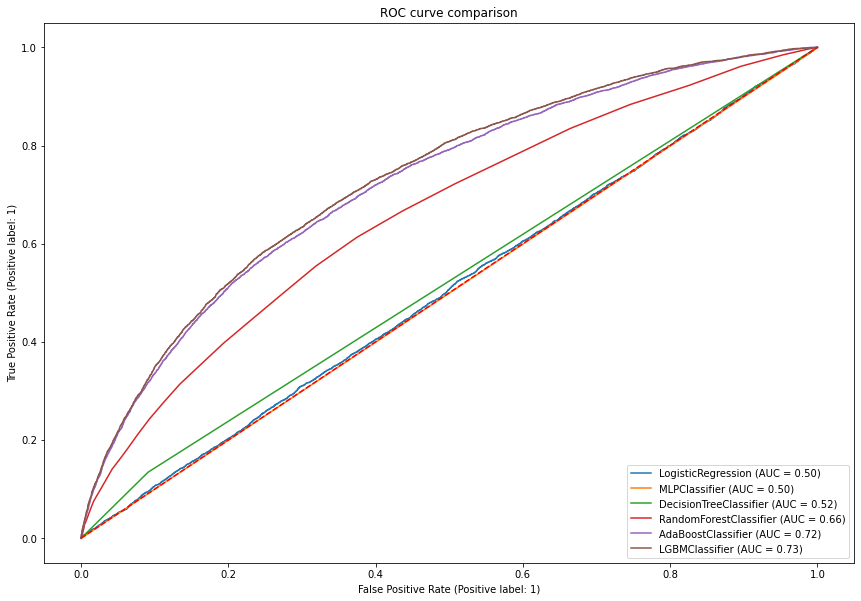

In [29]:
plt.figure(figsize=(18,8))
fig, ax = plt.subplots()
LR_disp = plot_roc_curve(LR, X_test, y_test,ax = ax)
#     example = plot_roc_curve(gbm_per, X_test_per, y_test_per, ax= ax, name = "LogostocRegression(AUC = 0.74)")
# gnb_disp = plot_roc_curve(gnb, X_test, y_test,ax = ax)
dnn_disp = plot_roc_curve(dnn, X_test, y_test,ax = ax)
clf_disp = plot_roc_curve(clf, X_test, y_test,ax = ax)
rfc_disp = plot_roc_curve(rfc, X_test, y_test,ax= ax)
ada_disp = plot_roc_curve(ada, X_test, y_test,ax= ax)
ada_disp = plot_roc_curve(gbm, X_test, y_test,ax= ax)

ax.plot([0, 1], [0, 1], linestyle='--', color='r')
plt.subplots_adjust( right=2, top = 2)
ax.set_title("ROC curve comparison")

In [ ]:
features = data_A.columns
X = X_train
y = y_train


# gbm
gbm = lgb.LGBMClassifier(
        boosting_type='gbdt',
        num_leaves=20,
        max_depth=8,
        learning_rate=0.02,
        n_estimators= 10000,
        objective='binary',
        class_weight=None,
        min_split_gain=0.0222415,
        min_child_weight=60,
        min_child_samples=200,
        subsample=0.8715623,
        subsample_freq=1,
        colsample_bytree=0.9497036,
        reg_alpha=0.041545473,
        reg_lambda=0.0735294,
        random_state=42,
        n_jobs=-1

    )

gbm.fit(X, y)

# Extract feature importances
feature_importance_values = gbm.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

def plot_feature_importances(df):
    
    df = df.sort_values('importance', ascending = False).reset_index()
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    return df

feature_importances_sorted = plot_feature_importances(feature_importances)

# 添加LSTM_Feature

In [58]:
data_B = pd.read_csv("C:/data/processing_data/data_app.csv")
data_B = reduce_mem_usage(data_B)
data_B.shape

Memory usage of dataframe: 520.84 MB
Memory usage after optimization: 130.50 MB
Decreased by 74.9%


(307511, 222)

In [59]:
data_B

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_0,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET
0,100002,-0.324463,-0.717773,0.664551,-0.577637,0.142090,-0.478027,-0.166016,-0.505859,-0.149658,...,-0.086731,-0.076294,-0.072876,-0.522949,1.934570,-0.133179,-0.949219,0.963867,-0.087341,1
1,100003,-0.324463,-0.717773,-1.504883,-0.577637,0.426758,1.725586,0.592773,1.600586,-1.252930,...,-0.086731,-0.076294,-0.072876,-0.522949,-0.516602,-0.133179,-0.949219,0.963867,-0.087341,0
2,100004,3.082031,1.392578,0.664551,-0.577637,-0.427246,-1.153320,-1.404297,-1.089844,-0.783203,...,-0.086731,-0.076294,-0.072876,-0.522949,-0.516602,-0.133179,1.053711,-1.038086,-0.087341,0
3,100006,-0.324463,-0.717773,0.664551,-0.577637,-0.142578,-0.711426,0.177979,-0.651855,-0.929199,...,-0.086731,-0.076294,-0.072876,-0.522949,-0.516602,-0.133179,1.053711,-1.038086,-0.087341,0
4,100007,-0.324463,-0.717773,0.664551,-0.577637,-0.199463,-0.213745,-0.361572,-0.067383,0.562988,...,-0.086731,-0.076294,-0.072876,-0.522949,-0.516602,-0.133179,1.053711,-1.038086,-0.087341,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,-0.324463,-0.717773,-1.504883,-0.577637,-0.047638,-0.855469,0.031082,-0.846680,0.845215,...,-0.086731,-0.076294,-0.072876,-0.522949,1.934570,-0.133179,-0.949219,0.963867,-0.087341,0
307507,456252,-0.324463,-0.717773,0.664551,-0.577637,-0.408203,-0.818359,-1.041992,-0.846680,0.310303,...,-0.086731,-0.076294,-0.072876,-0.522949,1.934570,-0.133179,-0.949219,0.963867,-0.087341,0
307508,456253,-0.324463,-0.717773,0.664551,-0.577637,-0.066650,0.195435,0.198120,0.127441,-1.147461,...,-0.086731,-0.076294,-0.072876,1.912109,-0.516602,-0.133179,-0.949219,0.963867,-0.087341,0
307509,456254,-0.324463,-0.717773,0.664551,-0.577637,0.009285,-0.568848,-0.476318,-0.590820,-1.124023,...,-0.086731,-0.076294,-0.072876,-0.522949,1.934570,-0.133179,-0.949219,0.963867,-0.087341,1


In [60]:
data_LSTM = pd.read_csv("C:/data/processing_data/LSTM_Feature.csv")
data_LSTM = reduce_mem_usage(data_LSTM)
data_LSTM.shape

Memory usage of dataframe: 77.42 MB
Memory usage after optimization: 19.94 MB
Decreased by 74.2%


(307511, 33)

In [61]:
data_LSTM

,SK_ID_CURR,LSTM_1,LSTM_2,LSTM_3,LSTM_4,LSTM_5,LSTM_6,LSTM_7,LSTM_8,LSTM_9,...,LSTM_23,LSTM_24,LSTM_25,LSTM_26,LSTM_27,LSTM_28,LSTM_29,LSTM_30,LSTM_31,LSTM_32
0,100002,0.0,0.0,0.047943,0.675781,0.0,0.0,0.0,0.039154,0.0,...,0.262939,0.0,0.162842,0.139404,0.488281,0.0,0.0,0.624512,0.304199,0.323242
1,100003,0.0,0.0,0.243164,2.429688,0.0,0.0,0.0,0.916504,0.0,...,0.622070,0.0,0.825195,0.000000,1.728516,0.0,0.0,2.693359,1.545898,1.300781
2,100004,0.0,0.0,0.209839,1.746094,0.0,0.0,0.0,0.819824,0.0,...,0.556152,0.0,0.493408,0.729492,1.445312,0.0,0.0,2.021484,0.999512,0.889160
3,100006,0.0,0.0,0.185913,1.388672,0.0,0.0,0.0,0.582520,0.0,...,0.650391,0.0,0.457764,0.000000,1.086914,0.0,0.0,1.581055,0.726074,0.801758
4,100007,0.0,0.0,0.283447,1.401367,0.0,0.0,0.0,0.648438,0.0,...,0.322754,0.0,0.527832,0.000000,1.129883,0.0,0.0,1.547852,0.803223,0.759277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0.0,0.0,0.135742,1.352539,0.0,0.0,0.0,0.501465,0.0,...,0.681641,0.0,0.379883,0.000000,1.107422,0.0,0.0,1.379883,0.635742,0.679688
307507,456252,0.0,0.0,0.297607,1.447266,0.0,0.0,0.0,0.560547,0.0,...,0.115967,0.0,0.510742,0.000000,1.006836,0.0,0.0,1.624023,0.885254,1.083008
307508,456253,0.0,0.0,0.203613,1.808594,0.0,0.0,0.0,0.869141,0.0,...,0.535645,0.0,0.757812,0.218872,1.798828,0.0,0.0,2.322266,1.127930,0.837402
307509,456254,0.0,0.0,0.128662,0.952637,0.0,0.0,0.0,0.298584,0.0,...,0.514160,0.0,0.268555,0.661133,0.613281,0.0,0.0,0.959473,0.445312,0.591797


In [62]:
data_LSTM.drop(labels = ["SK_ID_CURR"], axis  = 1, inplace = True)

In [63]:
data_B = pd.concat([data_B, data_LSTM], axis = 1)
del data_LSTM
gc.collect()


4462

In [64]:
# data_B = data_B.sample(frac = 0.1)

In [65]:
train_df, test_df = split_train(data_B, 0.2)
feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X_train = train_df[feats].to_numpy()
y_train = train_df['TARGET'].values  
X_test = test_df[feats].to_numpy()                   
y_test = test_df['TARGET'].values

In [66]:
model_process(X_train, y_train, X_test, y_test)

=============================逻辑回归================================
训练开始


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


训练结束
训练集精确度:{0.919}     测试集精确度:{0.920}    

predict_proba 训练集auc:{0.746}  训练集auc:{0.741}

classification_report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56601
           1       0.60      0.01      0.01      4901

    accuracy                           0.92     61502
   macro avg       0.76      0.50      0.48     61502
weighted avg       0.89      0.92      0.88     61502

LR 的KS:{0.3535}
=============================DNN================================
训练开始
训练结束
训练集精确度:{0.9190}     测试集精确度:{0.9202}    

predict_proba 训练集auc:{0.7385}  训练集auc:{0.7333}

classification_report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56601
           1       0.14      0.00      0.00      4901

    accuracy                           0.92     61502
   macro avg       0.53      0.50      0.48     61502
weighted avg       0.86      0.92      0.88     61502

dnn 的KS:{0.3429}
=============

(LogisticRegression(max_iter=500, n_jobs=-1, random_state=42, solver='sag'),
 MLPClassifier(alpha=0.01, hidden_layer_sizes=(400,), learning_rate_init=0.01,
               max_iter=300),
 DecisionTreeClassifier(random_state=0),
 RandomForestClassifier(),
 AdaBoostClassifier(n_estimators=100, random_state=0),
 LGBMClassifier())

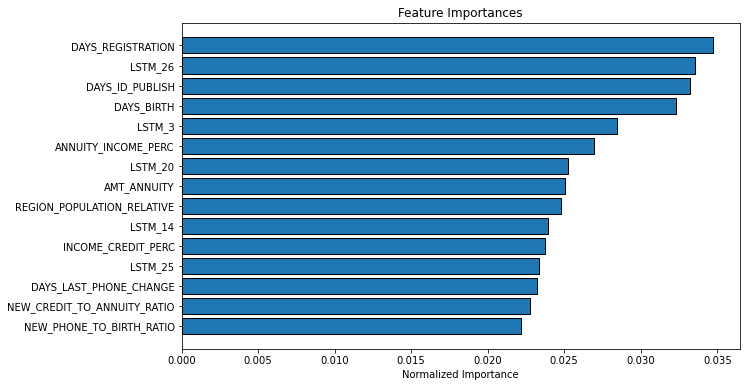

In [52]:

X = X_train
y = y_train
features =feats
# gbm
gbm = lgb.LGBMClassifier(
        boosting_type='gbdt',
        num_leaves=20,
        max_depth=8,
        learning_rate=0.02,
        n_estimators= 10000,
        objective='binary',
        class_weight=None,
        min_split_gain=0.0222415,
        min_child_weight=60,
        min_child_samples=200,
        subsample=0.8715623,
        subsample_freq=1,
        colsample_bytree=0.9497036,
        reg_alpha=0.041545473,
        reg_lambda=0.0735294,
        random_state=42,
        n_jobs=-1

    )

gbm.fit(X, y)

# Extract feature importances
feature_importance_values = gbm.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

def plot_feature_importances(df):
    
    df = df.sort_values('importance', ascending = False).reset_index()
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    plt.xlabel('Normalized Importance');
    plt.title('Feature Importances')
    
    plt.show()
    return df

feature_importances_sorted = plot_feature_importances(feature_importances)

In [56]:
feature_importances_sorted.head(20)

,index,feature,importance,importance_normalized
0,11,DAYS_REGISTRATION,6534,0.034720
1,245,LSTM_26,6313,0.033546
2,12,DAYS_ID_PUBLISH,6251,0.033217
3,9,DAYS_BIRTH,6080,0.032308
4,222,LSTM_3,5356,0.028461
5,71,ANNUITY_INCOME_PERC,5071,0.026946
6,239,LSTM_20,4755,0.025267
7,6,AMT_ANNUITY,4718,0.025071
8,8,REGION_POPULATION_RELATIVE,4665,0.024789
9,233,LSTM_14,4500,0.023912
